In [1]:
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt

from libs.util import readImg, psnr

## 1. Detect Tamper
Check Embedded Image

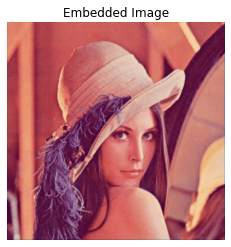

In [2]:
Origin_image = readImg("../_Image Data/Lenna/lena_color.gif")
Image = imageio.imread("./img/output/lena_embedded_eb=3.png")
H, W = Image.shape[:2]
plt.imshow(Image)
plt.title("Embedded Image")
plt.axis('off')
plt.show()

### 1-1. Init 

In [3]:
## User Requirerments
## Random Seed
_Sd = 7

## Permutation Key
_PK = 7

## Length of Embedding Codes (>=3) 
_eb = 3
if _eb < 3:
    raise 'eb can not be less than 3'


## block size = m*m
_m = 4

## recovery code bit
_n = 2

## Length of the Authentication Codes
_t = _eb-_n

working_image = np.copy(Image)

### 1-2. Authentication Code and Recovery Code Generation 

In [4]:
def generate_ac(height, width, seed, t_bitLength):
    random.seed(seed)
    ac = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            for k in range(ac.shape[2]):
                ac[i, j, k] = random.randint(0, 2**t_bitLength-1)
    return ac
## AMBTC basic
def AMBTC_encode_block(block):
    Ii = np.average(block)
    Bi = np.array(block > Ii, dtype=np.bool)
    ai = np.around(np.mean((Bi*block)[Bi > 0])).astype(np.uint8)
    bi = np.around(np.mean((~Bi*block)[Bi <= 0])).astype(np.uint8)
    return ai if ai is np.nan else bi, bi, Bi

def AMBTC_decode_block(ai, bi, Bi):
    return ai*Bi + bi*(~Bi)

## AMBTC recovery codes encoding
def encodeing2nBitBlock_ambtc(array):
    encoded = np.array(array)
    block = np.zeros((_m, _m), dtype=np.uint8)
    block[0, 0:_m] = split2nBitArray(encoded[0])
    block[1, 0:_m] = split2nBitArray(encoded[1])
    block[2:_m, 0:_m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(_m-2, _m)
    return block

def encodeing2nBitBlock(block):
    encoded = np.array(AMBTC_encode_block(block))
    block = np.zeros((_m, _m), dtype=np.uint8)
    block[0, 0:_m] = split2nBitArray(encoded[0])
    block[1, 0:_m] = split2nBitArray(encoded[1])
    block[2:_m, 0:_m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(_m-2, _m)
    return block

def split2nBitArray(num, bit_size=8):
    num_array = np.zeros(bit_size//_n, dtype=np.uint8)
    for i in range(bit_size//_n):
        # num_array[-i]=(num % 2**n)
        num_array[bit_size//_n-i-1]=(num % 2**_n)
        num = num >> _n
    return num_array

def flattenBinaryArray2nBitArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)//_n, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//_n] = num_array[i//_n]*2 + fArr[i]
    return num_array

def encode2nBitBlocks_color_image(image):
    blocks = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, _m):
        for j in range(0, W, _m):
            for k in range(0, 3):
                blocks[i:i+_m, j:j+_m, k] = encodeing2nBitBlock(image[i:i+_m, j:j+_m, k])
    return blocks

## AMBTC recovery codes decoding
def convert_nBitBlock2EncodedData(block):
    ambtc_encoded_data = [0, 0, np.array((_m, _m), dtype=np.bool)]

    ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:_m])
    ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:_m])
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:_m, 0:_m]).reshape(_m, _m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)*_n, dtype=np.bool)
    for i in range (len(fArr)):
        num_array[-i] = fArr[-(i//_n)] % 2 == True
        fArr[-(i//_n)] = fArr[-(i//_n)] >> _n
    return num_array

def decode2nBitBlocks_color_image(image):
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, _m):
        for j in range(0, W, _m):
            for k in range(0, 3):
                enData = convert_nBitBlock2EncodedData(image[i:i+_m, j:j+_m, k])
                deData[i:i+_m, j:j+_m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData

### 1-3. Permutation, Repermutation, LowOrder

In [17]:
### The original method to permutation used the np.random
def permuted_3(perm, height, width, seed):
    np.random.seed(seed)
    _perm = np.array(perm).ravel().reshape((1,height*width))
    permutation = list(np.random.permutation(height*width))
    return _perm[:, permutation].reshape(height, width)

def rePermuted_3(perm, height, width, seed):
    np.random.seed(seed)
    _perm = np.array(perm).ravel().reshape((1,height*width))
    permutation = list(np.random.permutation(height*width))
    rePermutation = sorted(range(len(permutation)), key=lambda k: permutation[k])
    return _perm[:, rePermutation].reshape(height, width)

In [5]:
### Get the low-order bits of the array
#### Bits is number or (start_bit, end_bit)
def getLowOrder(X, bits):
    # print("DEBUG", type(bits), bits)
    if isinstance(bits, int):
        return np.array(X) & ((1 << bits) - 1)
    else:
        return (np.array(X) & ((1 << bits[1]) - 1)) >> (bits[0]-1)


### Set the low-order bits of the array
def setLowOrder(X, bits, value):
    return (np.copy(X) & ~((1 << bits) - 1)) | value

### 1-4. Tamper Detection

Check authentication Codes:  True


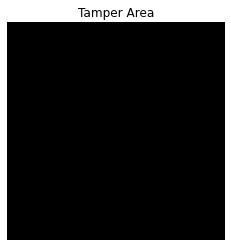

In [7]:
acs = generate_ac(H, W, _Sd, _t)
enbedded_acs = getLowOrder(working_image, (3, _eb))
print("Check authentication Codes: ", np.array_equal(acs, enbedded_acs))

unDetect_acs = acs == enbedded_acs
unDetect_acs = unDetect_acs[:, :, 0] & unDetect_acs[:, :, 1] & unDetect_acs[:, :, 2]
plt.imshow(unDetect_acs, cmap='gray')
plt.title("Tamper Area")
plt.axis('off')
plt.show()

### 1-5. Detecting Tamper Image

In [8]:
tampered_image = imageio.imread("./img/output/lena_embedded_eb=3_tp=1.png")
## 經過photoshop修改的圖片會變成(512, 512, 4)，所以把他轉回來
tampered_image = tampered_image[:, :, 0:3]

Check authentication Codes:  False


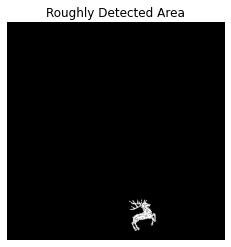

In [9]:
acs = generate_ac(H, W, _Sd, _t)
tampered_acs = getLowOrder(tampered_image, (3, _eb))
print("Check authentication Codes: ", np.array_equal(acs, tampered_acs))

detected_area = ~(acs == tampered_acs)
detected_area = (detected_area[:, :, 0] | detected_area[:, :, 1] | detected_area[:, :, 2])
plt.imshow(detected_area, cmap='gray')
plt.title("Roughly Detected Area")
plt.axis('off')
plt.show()

### 1-6. Finally Detect Porcess

Before


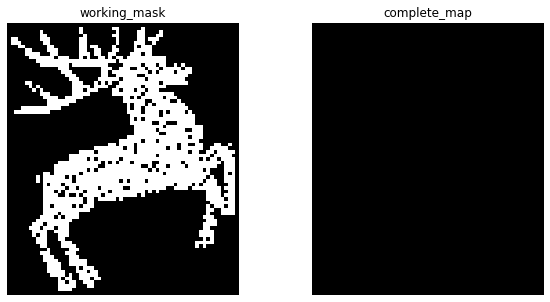

In [10]:
detected_arg = np.argwhere(detected_area == True)
patch = [
    [detected_arg[:, 0].min(), detected_arg[:, 1].min()],
    [detected_arg[:, 0].max(), detected_arg[:, 1].max()]
]
patch_height, patch_width = patch[1][0] - patch[0][0]+1, patch[1][1] - patch[0][1]+1

working_mask = np.zeros((patch_height+2, patch_width+2), dtype=np.bool)
working_mask[1:-1, 1:-1] = detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1]
work_height, work_width = working_mask.shape[0:2]
complete_map = np.zeros(shape=(work_height, work_width), dtype=np.bool)


print("Before")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

In [11]:
def refinement(y, x):
    ## 是否已檢測過
    complete_map[y, x] = True
    cases = np.array([
        [
            [1, 0, 0],
            [0, 0, 0],
            [0, 0, 1]
        ],
        [
            [0, 1, 0],
            [0, 0, 0],
            [0, 1, 0]
        ],
        [
            [0, 0, 1],
            [0, 0, 0],
            [1, 0, 0]
        ],
        [
            [0, 0, 0],
            [1, 0, 1],
            [0, 0, 0]
        ]
    ])
    cases_range = np.array([
        [
            [-2, 0],
            [-2, 0],
        ],
        [
            [-2, 0],
            [-1, 1]
        ],
        [
            [-2, 0],
            [0, 2]
        ],
        [
            [-1, 1],
            [0, 2]
        ],
        [
            [0, 2],
            [0, 2]
        ],
        [
            [0, 2],
            [-1, 1]
        ],
        [
            [0, 2],
            [-2, 0]
        ],
        [
            [-1, 1],
            [-2, 0]
        ]
    ])
    
    for i in range(8):
        case_patch = [
            [y+cases_range[i, 0, 0], y+cases_range[i, 0, 1]],
            [x+cases_range[i, 1, 0], x+cases_range[i, 1, 1]]
        ]
        if case_patch[0][0]<0 or case_patch[0][1]>=work_height or case_patch[1][0]<0 or case_patch[1][1]>=work_width:
            continue
        block = working_mask[case_patch[0][0]:case_patch[0][1]+1, case_patch[1][0]:case_patch[1][1]+1]*cases[i%4]
        if np.array_equal(block, cases[i%4]):
            ap_point = [y+cases_range[i, 0].sum()//2, x+cases_range[i, 1].sum()//2]
            if ap_point[0]>=0 and ap_point[0]<=work_height and ap_point[1]>=0 and ap_point[1]<=work_width:
                working_mask[ap_point[0], ap_point[1]] = True
                if complete_map[ap_point[0], ap_point[1]] == False:
                    refinement(ap_point[0], ap_point[1])
    return True

After


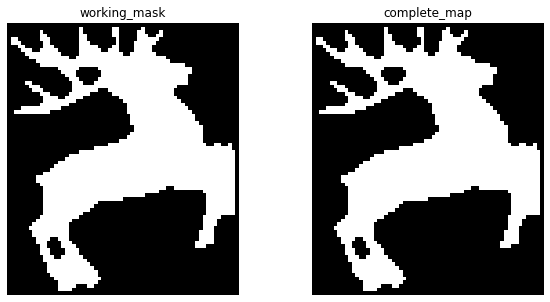

In [12]:
for p in detected_arg:
    try:
        y, x = p[0]-patch[0][0], p[1]-patch[0][1]
        refinement(y+1, x+1)
        if np.array_equal(working_mask, complete_map):
            break
    except RecursionError as e:
        print("[RecursionError]", e, "Try Again!!")
print("After")
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(working_mask, cmap="gray")
axs[0].set_title("working_mask")
axs[0].axis('off')
axs[1].imshow(complete_map, cmap="gray")
axs[1].set_title("complete_map")
axs[1].axis('off')
plt.show()

In [13]:
def getImageTrueArea(image, detected):
    _image = np.copy(image)
    if detected.ndim == 2:
        _image[:, :, 0]*=detected
        _image[:, :, 1]*=detected
        _image[:, :, 2]*=detected
    else:
        _image[:, :, 0]*=detected[:, :, 0]
        _image[:, :, 1]*=detected[:, :, 1]
        _image[:, :, 2]*=detected[:, :, 2]
    return _image

In [14]:
finally_detected_area = detected_area
finally_detected_area[patch[0][0]:patch[1][0]+1, patch[0][1]:patch[1][1]+1] = working_mask[1:-1, 1:-1]
finally_detected_size = (working_mask).sum()
finally_detected_image = getImageTrueArea(tampered_image, ~finally_detected_area)

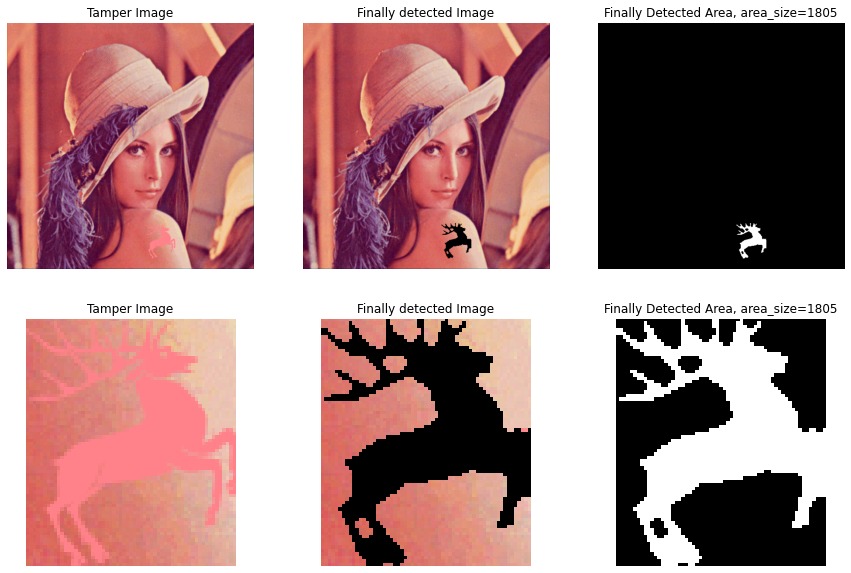

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].set_title("Tamper Image")
axs[0, 0].imshow(tampered_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Finally detected Image")
axs[0, 1].imshow(finally_detected_image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[0, 2].imshow(finally_detected_area, cmap="gray")
axs[0, 2].axis('off')
axs[1, 0].set_title("Tamper Image")
axs[1, 0].imshow(tampered_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].set_title("Finally detected Image")
axs[1, 1].imshow(finally_detected_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].set_title("Finally Detected Area, area_size={}".format(finally_detected_size))
axs[1, 2].imshow(finally_detected_area[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]], cmap="gray")
axs[1, 2].axis('off')
plt.show()

## 2. Recovery Image

In [28]:
enbedded_rcs = getLowOrder(finally_detected_image, 2)
rePermuted_enbedded_rcs = np.zeros((H, W, 3), dtype=np.uint8)
rePermuted_enbedded_rcs[:, :, 0] = rePermuted_3(enbedded_rcs[:, :, 0], _Sd)
rePermuted_enbedded_rcs[:, :, 1] = rePermuted_3(enbedded_rcs[:, :, 1], _Sd)
rePermuted_enbedded_rcs[:, :, 2] = rePermuted_3(enbedded_rcs[:, :, 2], _Sd)

rePermuted_enbedded_rcs

TypeError: rePermuted_3() missing 2 required positional arguments: 'width' and 'seed'

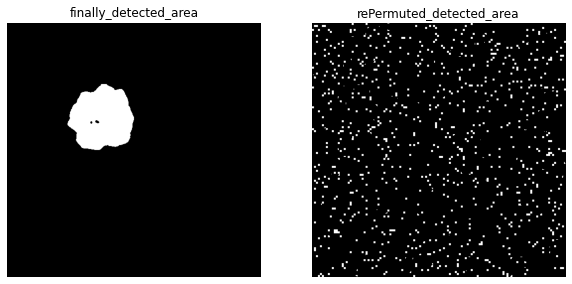

In [21]:
rePermuted_detected_area = rePermuted_3(finally_detected_area, _Sd)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(finally_detected_area, cmap="gray")
axs[0].set_title("finally_detected_area")
axs[0].axis('off')
axs[1].imshow(rePermuted_detected_area, cmap="gray")
axs[1].set_title("rePermuted_detected_area")
axs[1].axis('off')
plt.show()

- AMBTC被破壞的部分如何進行抉擇?
- 如果是ai, bi被破壞，要完全黑化，還是如果破壞不多，可以允許? 範圍是多少?
- Bi 可以直接只對被影響的像素黑化，可不至於整塊黑掉


In [18]:
# # Building
# ## AMBTC recovery codes decoding
# def convert_nBitBlock2EncodedData(block, mask):
#     ambtc_encoded_data = [0, 0, np.array((m, m), dtype=np.bool)]

#     if mask[0, 0:m].sum(): 
#         ambtc_encoded_data[0] = 0
#     else:
#         ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:m])

#     if mask[1, 0:m].sum():
#         ambtc_encoded_data[1] = 0
#     else:
#         ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:m])
    
#     bit_map, bit_map_mask = combine_nBitArray2BinaryArray(block[2:m, 0:m], mask[2:m, 0:m])
#     ambtc_encoded_data[2] = bit_map.reshape(m, m)
#     return ambtc_encoded_data, bit_map_mask.reshape(m, m)

# def combine_nBitArray2Num(arr, bit_size=8):
#     num = 0
#     for a in arr:
#         num = num << (bit_size//len(arr))
#         num+=a
#     return num

# def combine_nBitArray2BinaryArray(arr, mask):
#     fArr = arr.flatten()*~mask.flatten()
#     fMask = mask.flatten()
#     bit_map = np.zeros(len(fArr)*n, dtype=np.bool)
#     bit_map_mask = np.zeros(len(fArr)*n, dtype=np.bool)
#     for i in range(bit_map.shape[0]):
#         bit_map_mask[i] = fMask[(i//n)]
#         bit_map[bit_map.shape[0]-1-i] = fArr[fArr.shape[0]-1-(i//n)] % 2
#         fArr[fArr.shape[0]-1-(i//n)] = fArr[fArr.shape[0]-1-(i//n)] >> 1
#     return bit_map, bit_map_mask

# def decode2nBitBlocks_color_image(image, mask=None):
#     if mask is None:
#         mask = np.zeros((H, W), dtype=np.bool)
#     ambtc_mask = np.zeros((H, W, 3), dtype=np.bool)
#     deData = np.zeros((H, W, 3), dtype=np.uint8)
#     for i in range(0, H, m):
#         for j in range(0, W, m):
#             for k in range(0, 3):
#                 enData, block_mask = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k], mask[i:i+m, j:j+m])
#                 deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
#                 ambtc_mask[i:i+m, j:j+m, k] = block_mask
#     return getImageTrueArea(deData, ~ambtc_mask)

# ## Before
# # def decode2nBitBlocks_color_image(image, mask):
# #     deData = np.zeros((H, W, 3), dtype=np.uint8)
# #     for i in range(0, H, m):
# #         for j in range(0, W, m):
# #             for k in range(0, 3):
# #                 enData = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k], mask[i:i+m, j:j+m])
# #                 deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
# #     return deData

In [25]:

## AMBTC recovery codes decoding
def convert_nBitBlock2EncodedData(block, mask):
    ambtc_encoded_data = [0, 0, np.array((_m, _m), dtype=np.bool)]

    if mask[0, 0:_m].sum(): 
        ambtc_encoded_data[0] = 0
    else:
        ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:_m])

    if mask[1, 0:_m].sum():
        ambtc_encoded_data[1] = 0
    else:
        ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:_m])
    
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:_m, 0:_m], mask[2:_m, 0:_m]).reshape(_m, _m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr, mask):
    # fArr = arr.flatten()*~mask.flatten()
    fArr = arr.flatten()*mask.flatten()
    bit_map = np.zeros(len(fArr)*_n, dtype=np.bool)
    for i in range(bit_map.shape[0]):
        bit_map[bit_map.shape[0]-1-i] = fArr[fArr.shape[0]-1-(i//_n)] % 2
        fArr[fArr.shape[0]-1-(i//_n)] = fArr[fArr.shape[0]-1-(i//_n)] >> 1
    return bit_map

def decode2nBitBlocks_color_image(image, mask=None):
    if mask is None:
        mask = np.zeros((H, W), dtype=np.bool)
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, _m):
        for j in range(0, W, _m):
            for k in range(0, 3):
                enData = convert_nBitBlock2EncodedData(image[i:i+_m, j:j+_m, k], mask[i:i+_m, j:j+_m])
                deData[i:i+_m, j:j+_m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData

## Before
# def decode2nBitBlocks_color_image(image, mask):
#     deData = np.zeros((H, W, 3), dtype=np.uint8)
#     for i in range(0, H, m):
#         for j in range(0, W, m):
#             for k in range(0, 3):
#                 enData = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k], mask[i:i+m, j:j+m])
#                 deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
#     return deData

In [20]:
rePermuted_detected_arg = np.argwhere(rePermuted_detected_area == True)
# print(rePermuted_detected_arg[100:110])
mask_array = np.zeros((H//_m, W//_m), dtype=np.uint8)
for i in range(0, H, _m):
    for j in range(0, W, _m):
        mask_array[i//_m, j//_m] = rePermuted_detected_area[i:i+_m, j:j+_m].sum()
        if mask_array[i//_m, j//_m] == 3:
            print(i, j)


# fMask_array = mask_array.flatten()
# fMask_array = sorted(range(len(fMask_array)), key=lambda k: fMask_array[k])
# fMask_array.reshape(H//m, W//m)

0 0
0 156
0 228
0 252
0 320
0 400
0 484
0 496
4 12
4 64
4 80
4 216
4 356
4 372
4 400
4 412
4 416
8 84
8 108
8 116
8 180
8 248
8 284
8 288
8 372
8 376
8 432
12 32
12 60
12 176
12 284
12 316
16 56
16 60
16 152
16 280
16 388
20 136
20 184
20 252
20 264
20 460
24 48
24 180
24 284
24 312
24 344
24 404
24 472
28 4
28 36
28 68
28 96
28 108
28 216
28 244
28 252
28 284
28 340
28 460
32 76
32 80
32 88
32 136
32 168
32 280
32 296
32 340
32 476
36 20
36 32
36 76
36 132
36 264
36 324
36 468
40 24
40 104
40 288
40 404
40 444
44 8
44 24
44 68
44 176
44 184
44 208
44 212
44 348
44 384
48 32
48 40
48 160
48 180
48 360
48 364
48 368
48 424
52 148
52 172
52 220
52 264
52 432
52 476
56 12
56 32
56 76
56 88
56 104
56 124
56 160
56 196
56 200
56 272
56 312
56 352
60 12
60 136
60 228
60 416
60 472
64 20
64 44
64 108
64 200
64 468
68 12
68 44
68 136
68 212
68 224
68 244
68 336
68 388
68 424
72 8
72 64
72 84
72 140
72 192
72 380
72 460
76 100
76 116
76 220
76 296
76 380
76 416
76 456
80 20
80 36
80 60
80 124
8

block [[3 0 2 0]
 [3 1 2 0]
 [0 3 0 3]
 [3 0 3 0]]


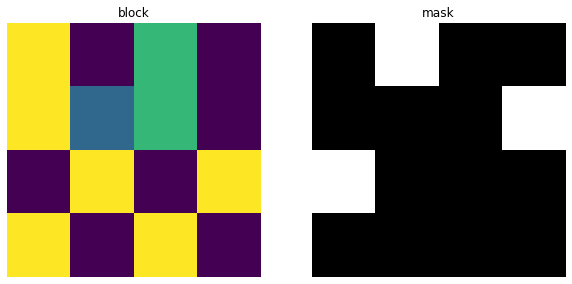

arr*~mask [[0 3 0 3]
 [3 0 3 0]]
bit_map [False False  True  True False False  True  True  True  True False False
  True  True False False]
bit_map_mask [ True  True False False False False False False False False False False
 False False False False]


([0,
  0,
  array([[False, False,  True,  True],
         [False, False,  True,  True],
         [ True,  True, False, False],
         [ True,  True, False, False]])],
 array([[ True,  True, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]))

In [21]:
def convert_nBitBlock2EncodedData(block, mask):
    ambtc_encoded_data = [0, 0, np.zeros((_m, _m), dtype=np.bool)]

    ## DEBUG
    print("block", block)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(block)
    axs[0].set_title("block")
    axs[0].axis('off')
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("mask")
    axs[1].axis('off')
    plt.show()
    

    if mask[0, 0:m].sum(): 
        ambtc_encoded_data[0] = 0
    else:
        ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:_m])

    if mask[1, 0:m].sum():
        ambtc_encoded_data[1] = 0
    else:
        ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:_m])
    
    bit_map, bit_map_mask = combine_nBitArray2BinaryArray(block[2:_m, 0:_m], mask[2:_m, 0:_m])
    ambtc_encoded_data[2] = bit_map.reshape(_m, _m)
    return ambtc_encoded_data, bit_map_mask.reshape(_m, _m)

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr, mask):
    print("arr*~mask", arr*~mask)
    fArr = arr.flatten()*~mask.flatten()
    fMask = mask.flatten()
    bit_map = np.zeros(len(fArr)*n, dtype=np.bool)
    bit_map_mask = np.zeros(len(fArr)*n, dtype=np.bool)
    for i in range(bit_map.shape[0]):
        bit_map_mask[i] = fMask[(i//n)]
        bit_map[bit_map.shape[0]-1-i] = fArr[fArr.shape[0]-1-(i//_n)] % 2
        fArr[fArr.shape[0]-1-(i//n)] = fArr[fArr.shape[0]-1-(i//_n)] >> 1
    print("bit_map", bit_map)
    print("bit_map_mask", bit_map_mask)
    return bit_map, bit_map_mask

convert_nBitBlock2EncodedData(rePermuted_enbedded_rcs[4:8, 400:404, 0], rePermuted_detected_area[4:8, 400:404])

Check The AMBTC image


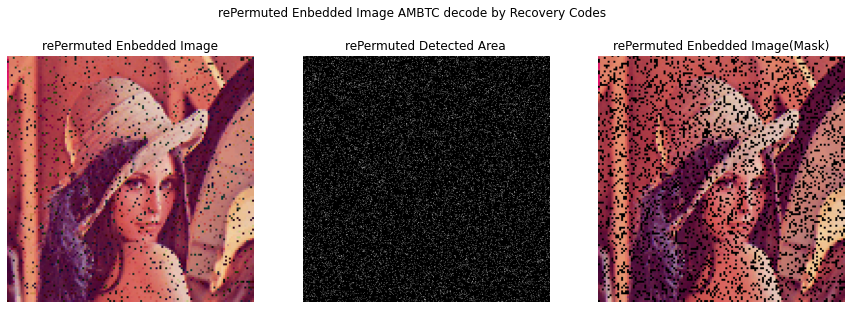

In [26]:
rePermuted_enbedded_image = decode2nBitBlocks_color_image(rePermuted_enbedded_rcs)
rePermuted_enbedded_image_mask = decode2nBitBlocks_color_image(rePermuted_enbedded_rcs, rePermuted_detected_area)
print("Check The AMBTC image")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("rePermuted Enbedded Image AMBTC decode by Recovery Codes")
axs[0].imshow(rePermuted_enbedded_image)
axs[0].set_title("rePermuted Enbedded Image")
axs[0].axis('off')
axs[1].imshow(rePermuted_detected_area, cmap="gray")
axs[1].set_title("rePermuted Detected Area")
axs[1].axis('off')
axs[2].imshow(rePermuted_enbedded_image_mask)
axs[2].set_title("rePermuted Enbedded Image(Mask)")
axs[2].axis('off')
plt.show()

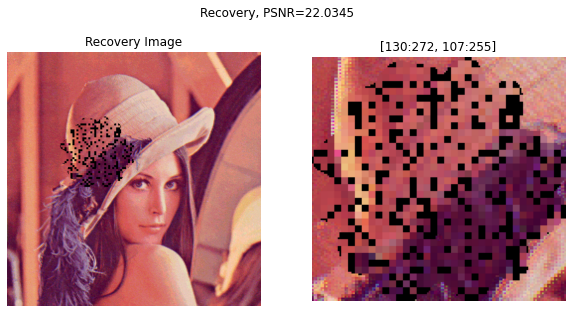

In [27]:
recovery_image = finally_detected_image + getImageTrueArea(rePermuted_enbedded_image_mask, finally_detected_area)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Recovery, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))))
axs[0].imshow(recovery_image)
axs[0].set_title("Recovery Image")
axs[0].axis('off')
axs[1].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1].set_title("[{}:{}, {}:{}]".format(patch[0][0], patch[1][0], patch[0][1], patch[1][1]))
axs[1].axis('off')
plt.show()

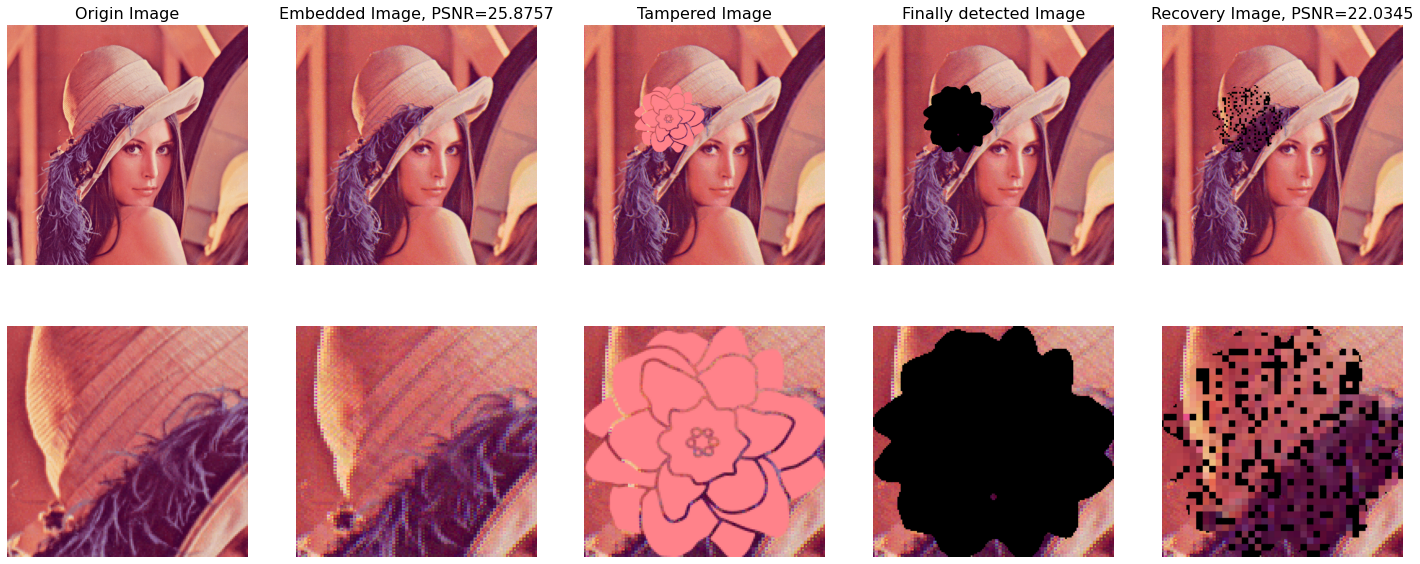

In [53]:
f_size = 16

fig, axs = plt.subplots(2, 5, figsize=(25, 10))
axs[0, 0].set_title("Origin Image", fontsize=f_size)
axs[0, 0].imshow(Origin_image)
axs[0, 0].axis('off')
axs[0, 1].set_title("Embedded Image, PSNR={:.4f}".format(psnr(Origin_image, Image.astype('uint8'))), fontsize=f_size)
axs[0, 1].imshow(Image)
axs[0, 1].axis('off')
axs[0, 2].set_title("Tampered Image", fontsize=f_size)
axs[0, 2].imshow(tampered_image)
axs[0, 2].axis('off')
axs[0, 3].set_title("Finally detected Image", fontsize=f_size)
axs[0, 3].imshow(finally_detected_image)
axs[0, 3].axis('off')
axs[0, 4].set_title("Recovery Image, PSNR={:.4f}".format(psnr(Origin_image, recovery_image.astype('uint8'))), fontsize=f_size)
axs[0, 4].imshow(recovery_image)
axs[0, 4].axis('off')
axs[1, 0].imshow(Origin_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 0].axis('off')
axs[1, 1].imshow(Image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 1].axis('off')
axs[1, 2].imshow(tampered_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 2].axis('off')
axs[1, 3].imshow(finally_detected_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 3].axis('off')
axs[1, 4].imshow(recovery_image[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
axs[1, 4].axis('off')
plt.show()